# Case Study 4

In [42]:
# Getting all imports out of the way first
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time 
from bs4 import BeautifulSoup as bs
import glob
from IPython.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer
import re

## 17.1 Extracting Skill Requirements from Job Postings

In [16]:
# Loading HTML files
html_contents = []

for file_name in sorted(glob.glob('./CaseStudyFiles/job_postings/*.html')):
    with open(file_name, 'r') as f:
        html_contents.append(f.read())

print(f"We've loaded {len(html_contents)} HTML files.")

We've loaded 1458 HTML files.


In [17]:
# Parsing HTML files
soup_objects = []
for html in html_contents:
    soup = bs(html)
    assert soup.title is not None
    assert soup.body is not None
    soup_objects.append(soup)

In [18]:
# Checking title and body texts for duplicates
html_dict = {'Title': [], 'Body': []}

for soup in soup_objects:
    title = soup.find('title').text
    body = soup.find('body').text
    html_dict['Title'].append(title)
    html_dict['Body'].append(body)

df_jobs = pd.DataFrame(html_dict)
summary = df_jobs.describe()
print(summary)


                                Title  \
count                            1458   
unique                           1364   
top     Data Scientist - New York, NY   
freq                               13   

                                                     Body  
count                                                1458  
unique                                               1458  
top     Data Scientist - Beavercreek, OH\nData Scienti...  
freq                                                    1  


### 17.1.1 Exploring the HTML for Skill Descriptions

In [19]:
# Rendering the HTML of the first job posting
assert len(set(html_contents)) == len(html_contents)
display(HTML(html_contents[0]))

In [20]:
# Rendering the HTML of the second job posting
display(HTML(html_contents[1]))

In [21]:
# Extracting bullets from the HTML
df_jobs['Bullets'] = [[bullet.text.strip() for bullet in soup.find_all('li')] for soup in soup_objects]

In [22]:
# Measuring the percent of bulleted postings
bulleted_post_count = 0 
for bullet_list in df_jobs.Bullets:
    if bullet_list:
        bulleted_post_count += 1

percent_bulleted = 100 * bulleted_post_count / df_jobs.shape[0]
print(f"{percent_bulleted:.2f}% of the postings contain bullets")

90.53% of the postings contain bullets


In [24]:
# Examining the top-ranked words in the HTML bullets
def rank_words(text_list):
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(text_list).toarray()
    df = pd.DataFrame({'Words': vectorizer.get_feature_names_out(), 'Summed TFIDF': tfidf_matrix.sum(axis=0)})
    sorted_df = df.sort_values('Summed TFIDF', ascending=False)
    return sorted_df

all_bullets = []
for bullet_list in df_jobs.Bullets:
    all_bullets.extend(bullet_list)

sorted_df = rank_words(all_bullets)
print(sorted_df[:5].to_string(index=False))

     Words  Summed TFIDF
experience    878.030398
      data    842.978780
    skills    440.780236
      work    371.684232
   ability    370.969638


In [25]:
# Examining the top-ranked words in the HTML bodies
non_bullets = []
for soup in soup_objects:
    body = soup.body
    for tag in body.find_all('li'):
        tag.decompose()

    non_bullets.append(body.text)

sorted_df = rank_words(non_bullets)
print(sorted_df[:5].to_string(index=False))

     Words  Summed TFIDF
      data     99.111312
      team     39.175041
      work     38.928948
experience     36.820836
  business     36.140488


In [26]:
# Checking titles for references to data science positions
regex = r'Data Scien(ce|tist)'
df_non_ds_jobs = df_jobs[~df_jobs.Title.str.contains(regex, case=False)]

percent_non_ds = 100 * df_non_ds_jobs.shape[0] / df_jobs.shape[0]
print(f"{percent_non_ds:.2f}% of the job posting titles do not mention a data science position. Below is a sample of such titles:\n")

for title in df_non_ds_jobs.Title[:10]:
    print(title)

64.33% of the job posting titles do not mention a data science position. Below is a sample of such titles:

Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL
Data Manager / Analyst - Oakland, CA
Scientific Programmer - Berkeley, CA
JD Digits - AI Lab Research Intern - Mountain View, CA
Operations and Technology Summer 2020 Internship-West Coast - Universal City, CA
Data and Reporting Analyst - Olympia, WA 98501
Senior Manager Advanced Analytics - Walmart Media Group - San Bruno, CA
Data Specialist, Product Support Operations - Sunnyvale, CA
Deep Learning Engineer - Westlake, TX
Research Intern, 2020 - San Francisco, CA 94105


C:\Users\meowm\AppData\Local\Temp\ipykernel_17864\3722151036.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_non_ds_jobs = df_jobs[~df_jobs.Title.str.contains(regex, case=False)]


In [29]:
# Sampling bullets from a non-data science job
bullets = df_non_ds_jobs.Bullets.iloc[0]
for i, bullet in enumerate(bullets[:5]):
    print(f"{i}: {bullet.strip()}")

0: Provides all personal care services in accordance with the plan of treatment assigned by the registered nurse
1: Accurately documents care provided
2: Applies safety principles and proper body mechanics to the performance of specific techniques of personal and supportive care, such as ambulation of patients, transferring patients, assisting with normal range of motions and positioning
3: Participates in economical utilization of supplies and ensures that equipment and nursing units are maintained in a clean, safe manner
4: Routinely follows and adheres to all policies and procedures


## 17.2 Filtering Jobs by Relevance

In [31]:
# Loading the resume
resume = open('CaseStudyFiles/resume.txt', 'r').read()
print(resume)

Experience

1. Developed probability simulations using NumPy.
2. Assessed online ad-clicks for statistical significance using Permutation testing.
3. Analyzed disease outbreaks using common clustering algorithms.

Additional Skills

1. Data visualization using Matplotlib.
2. Statistical analysis using SciPy.
3. Processing structured tables using Pandas.
4. Executing K-Means clustering and DBSCAN clustering using Scikit-Learn.
5. Extracting locations from text using GeonamesCache.
6. Location analysis and visualization using GeonamesCache and Basemap.
7. Dimensionality reduction with PCA and SVD, using Scikit-Learn.
8. NLP analysis and text topic detection using Scikit-Learn.


In [32]:
# Loading the table of contents
table_of_contents = open('./CaseStudyFiles/table_of_contents.txt', 'r').read()

In [33]:
# Combining skills into a single string
existing_skills = resume + table_of_contents

In [34]:
# Vectorizing our skills and the job-posting data
text_list = df_jobs.Body.values.tolist() + [existing_skills]
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text_list).toarray()

In [35]:
# Computing skill-based cosine similarities
cosine_similarities = tfidf_matrix[:-1] @ tfidf_matrix[-1]

In [36]:
# Printing the 20 least relevant jobs
df_jobs['Relevance'] = cosine_similarities
sorted_df_jobs = df_jobs.sort_values('Relevance', ascending=False)
for title in sorted_df_jobs[-20:].Title:
    print(title)

Data Analyst Internship (8 month minimum) - San Francisco, CA
Leadership and Advocacy Coordinator - Oakland, CA 94607
Finance Consultant - Audi Palo Alto - Palo Alto, CA
RN - Hattiesburg, MS
Configuration Management Specialist - Dahlgren, VA
Deal Desk Analyst - Mountain View, CA
Dev Ops Engineer AWS - Rockville, MD
Web Development Teaching Assistant - UC Berkeley (Berkeley) - Berkeley, CA
Scorekeeper - Oakland, CA 94612
Direct Care - All Experience Levels (CNA, HHA, PCA Welcome) - Norwell, MA 02061
Director of Marketing - Cambridge, MA
Certified Strength and Conditioning Specialist - United States
PCA - PCU Full Time - Festus, MO 63028
Performance Improvement Consultant - Los Angeles, CA
Patient Services Rep II - Oakland, CA
Lab Researcher I - Richmond, CA
Part-time instructor of Statistics for Data Science and Machine Learning - San Francisco, CA 94105
Plant Engineering Specialist - San Pablo, CA
Page Not Found - Indeed Mobile
Director of Econometric Modeling - External Careers


In [37]:
# Printing the 20 most relevant jobs
for title in sorted_df_jobs[:20].Title:
    print(title)

Chief Data Officer - Culver City, CA 90230
Data Scientist - Beavercreek, OH
Data Scientist Population Health - Los Angeles, CA 90059
Data Scientist - San Diego, CA
Data Scientist - Beavercreek, OH
Senior Data Scientist - New York, NY 10018
Data Architect - Raleigh, NC 27609
Data Scientist (PhD) - Spring, TX
Data Science Analyst - Chicago, IL 60612
Associate Data Scientist (BS / MS) - Spring, TX
Data Scientist - Streetsboro, OH 44241
Data Scientist - Los Angeles, CA
Sr Director of Data Science - Elkridge, MD
2019-57 Sr. Data Scientist - Reston, VA 20191
Data Scientist (PhD) - Intern - Spring, TX
Sr Data Scientist. - Alpharetta, GA 30004
Data Scientist GS 13/14 - Clarksburg, WV 26301
Data Science Intern (BS / MS) - Intern - Spring, TX
Senior Data Scientist - New York, NY 10038
Data Scientist - United States


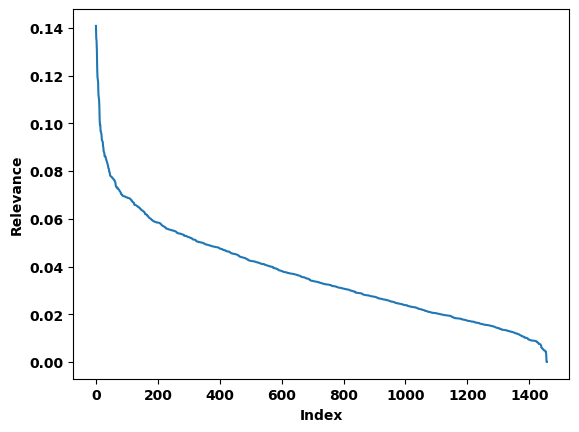

In [38]:
# Plotting job ranking vs. relevance
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs.Relevance.values)
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.show()

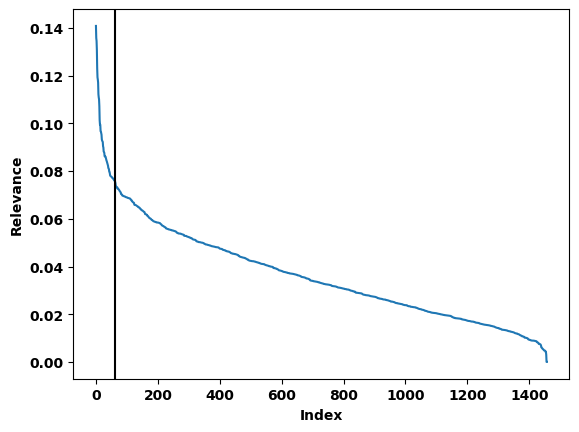

In [39]:
# Adding a cutoff to the relevance plot
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs.Relevance.values)
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.axvline(60, c='k')
plt.show()

In [40]:
# Printing jobs below the relevance cutoff
for title in sorted_df_jobs[40:60].Title.values:
    print(title)

Data Scientist III - Pasadena, CA 91101
Global Data Engineer - Boston, MA
Data Analyst and Data Scientist - Summit, NJ
Data Scientist - Generalist - Glendale, CA
Data Scientist - Seattle, WA
IT Data Scientist - Contract - Riverton, UT
Data Scientist (Analytic Consultant 4) - San Francisco, CA
Data Scientist - Seattle, WA
Data Science & Tagging Analyst - Bethesda, MD 20814
Data Scientist - New York, NY
Senior Data Scientist - Los Angeles, CA
Principal Statistician - Los Angeles, CA
Senior Data Analyst - Los Angeles, CA
Data Scientist - Aliso Viejo, CA 92656
Data Engineer - Seattle, WA
Data Scientist - Digital Factory - Tampa, FL 33607
Data Scientist - Grapevine, TX 76051
Data Scientist - Bioinformatics - Denver, CO 80221
EPIDEMIOLOGIST - Los Angeles, CA
Data Scientist - Bellevue, WA


In [41]:
# Printing jobs beyond the relevance cutoff
for title in sorted_df_jobs[60:80].Title.values:
    print(title)

Data Scientist - Aliso Viejo, CA
Data Scientist and Visualization Specialist - Santa Clara Valley, CA 95014
Data Scientist - Los Angeles, CA
Data Scientist Manager - NEW YORK LOCATION! - New York, NY 10036
Data Science Intern - San Francisco, CA 94105
Research Data Analyst - San Francisco, CA
Sr Data Scientist (Analytic Consultant 5) - San Francisco, CA
Data Scientist, Media Manipulation - Cambridge, MA
Manager, Data Science, Programming and Visualization - Boston, MA
Data Scientist in Broomfield, CO - Broomfield, CO
Senior Data Scientist - Executive Projects and New Solutions - Foster City, CA
Manager of Data Science - Burbank California - Burbank, CA
Data Scientist Manager - Hiring in Burbank! - Burbank, CA
Data Scientists needed in NY - Senior Consultants and Managers! - New York, NY 10036
Data Scientist - Menlo Park, CA
Data Engineer - Santa Clara, CA
Data Scientist - Remote
Data Scientist I-III - Phoenix, AZ 85021
SWE Data Scientist - Santa Clara Valley, CA 95014
Health Science Sp

In [43]:
# Measuring title relevance in a subset of jobs
def percent_relevant_title(df):
    regex_relevant = re.compile(r'Data (Scien|Analy)', flags=re.IGNORECASE)
    regex_irrelevant = re.compile(r'\b(Manage)', flags=re.IGNORECASE)
    match_count = len([title for title in df.Title if regex_relevant.search(title) and not regex_irrelevant.search(title)])
    percent = 100 * match_count / df.shape[0]
    return percent

percent = percent_relevant_title(sorted_df_jobs[60:80])
print(f"Approximately {percent:.2f}% of job titles between indices 60-80 are relevant")

Approximately 65.00% of job titles between indices 60-80 are relevant
